In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# %gui qt
import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from utils.image_utils import resize, scale_image, norm_uint8, CMO_op, BH_op, max_pool, min_pool
from utils.image_utils import *
from utils.show_images import *
import numpy as np

import cv2 as cv2
# import cupy as cp
import imutils

from imutils import resize
import napari

In [3]:
viewer = napari.Viewer()
napari.run()

In [4]:
root = get_project_root()
filename = root/'experiments/images/helicopter.JPG'
filename1 = root/'images/CanonEOSM100.JPG'
filename2 = root/'images/SonyA7III.JPG'
filename3 = root/'images/sonyA7III_shutter.JPG'
filename4 = root/'images/samsung_48mpix.jpg'
filename4 = root/'images/Samsung A22.jpg'
filename5 = root/'images/flir_12mpix.jpg'
# filename = '/home/jn/data/Karioitahi_15Jan2022/117MSDCF-28mm/DSC04377.JPG'
img_25mm = cv2.cvtColor(cv2.imread(str(filename1)), cv2.COLOR_RGB2BGR)
img_36mm_1 = cv2.cvtColor(cv2.imread(str(filename2)), cv2.COLOR_RGB2BGR)
img_36mm_2 = cv2.cvtColor(cv2.imread(str(filename3)), cv2.COLOR_RGB2BGR)
img_samsung48mpix = cv2.cvtColor(cv2.imread(str(filename4)), cv2.COLOR_RGB2BGR)
flir_12mpix = cv2.cvtColor(cv2.imread(str(filename5)), cv2.COLOR_RGB2BGR)

viewer.add_image(img_25mm)
viewer.add_image(img_36mm_1)
viewer.add_image(img_36mm_2)
viewer.add_image(img_samsung48mpix)
viewer.add_image(flir_12mpix)
# viewer.add_image(resize(gray_img, width=6000//12))

<Image layer 'flir_12mpix' at 0x7f38f19fe0d0>

In [7]:
viewer.add_image(img)

<Image layer 'img' at 0x7f990ee96c70>

<Image layer 'img_min_pool' at 0x7f0cbe626bb0>

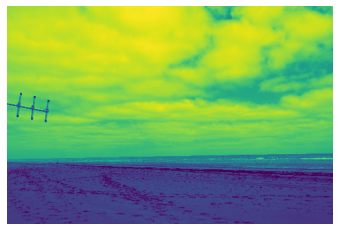

In [27]:
img_min_pool = min_pool(gray_img, 12, 12)
# img_min_pool[200:210, 250:260] = 0
# viewer.add_image(img_min_pool)
show_img(img_min_pool)
viewer.add_image(img_min_pool)

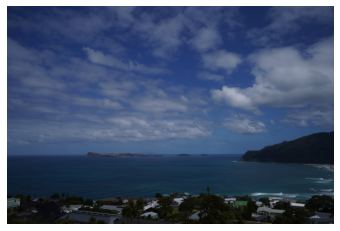

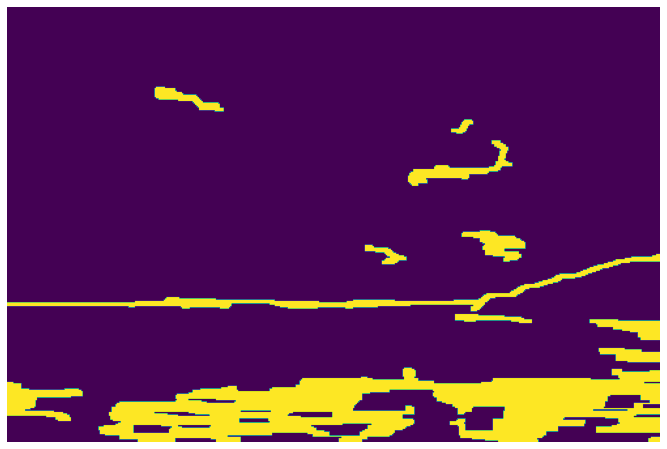

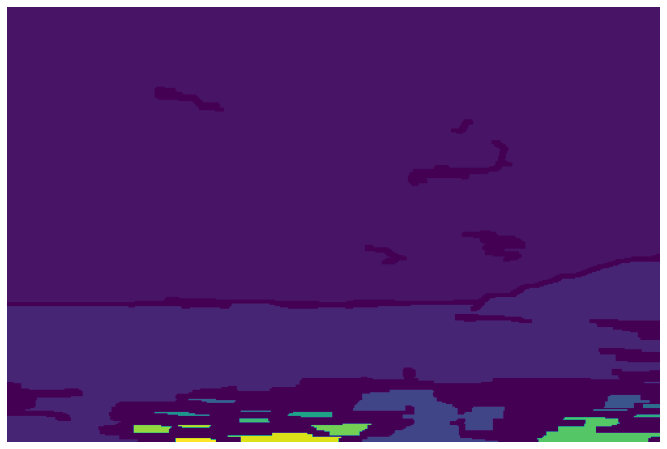

In [118]:
import math
filename = '/home/jn/data/Tairua/DSC03625.JPG'
# filename = '/home/jn/data/Karioitahi_15Jan2022/117MSDCF-28mm/DSC04377.JPG'
# filename = '/home/jn/data/Karioitahi_15Jan2022/123MSDCF-35mm/DSC01726.JPG'

imgrgb = cv2.imread(str(filename))
imgrgb_s = resize(imgrgb, width=6000//12)
gray_img_s = cv2.cvtColor(imgrgb_s, cv2.COLOR_BGR2GRAY)
show_img(imgrgb_s)
# edges = cv2.Canny(hsv[:,:,2],50,150,apertureSize = 3)
edges = cv2.Canny(gray_img_s,threshold1=50, threshold2=150,apertureSize = 3)
kernel = np.ones((3,5), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1) # < --- Added a dilate, check link I provided
kernel = np.ones((1,5), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=5)
# edges = cv2.morphologyEx(edges, cv2.MORPH_DILATE, kernel, iterations=1)
show_img(edges, figsize=(12,8))
# show_img(imgrgb_s, mode='BGR', figsize=(12,8))
mask = np.ones_like(edges, dtype='uint8')
mask[edges==255] = 0
num_regions, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
area_sort = np.argsort(stats[:, -1])

labels = labels*20

show_img(labels, figsize=(12,8))
# %timeit -n 3 -r 100  cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=6)
# %timeit -n 3 -r 100  resize(imgrgb, width=6000//12)
# %timeit -n 3 -r 100  cv2.cvtColor(imgrgb_s, cv2.COLOR_BGR2GRAY)
# %timeit -n 3 -r 100  min_pool(gray_img, 12, 12)

The slowest run took 4.67 times longer than the fastest. This could mean that an intermediate result is being cached.
383 µs ± 141 µs per loop (mean ± std. dev. of 100 runs, 3 loops each)


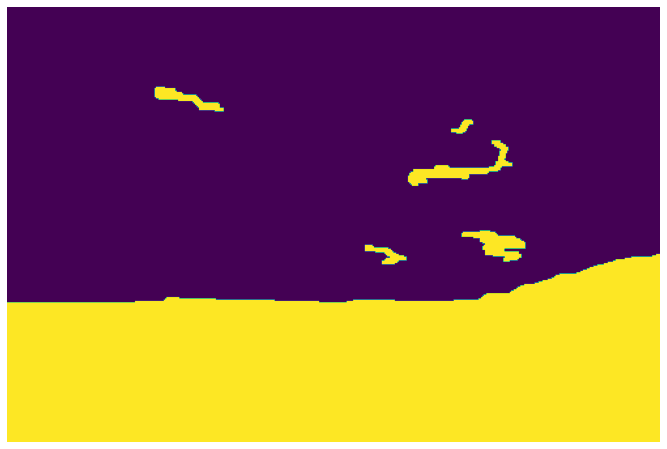

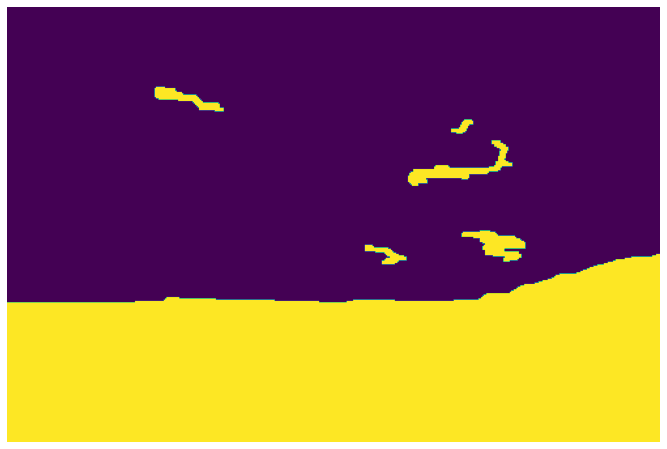

In [130]:
num_regions, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
area_sort = np.argsort(stats[:, -1])
# choose the region that is the largest brightest
brightest = 0
sky_idx = -1

# get bright large area
for i in range(min(num_regions, 3)):
    idx = area_sort[-(i+1)]
    b = np.mean(gray_img_s[labels==idx])
    area_ratio = stats[idx][4]/(mask.shape[0]*mask.shape[1])
    if b > brightest and area_ratio > 0.25:
        brightest = b
        sky_idx = idx

assert sky_idx > -1
labels[labels != sky_idx] = 255
labels[labels == sky_idx] = 0
labels = labels.astype('uint8')
kernel = np.ones((5,5), 'uint8')
show_img(labels, figsize=(12,8))
# labels = cv2.morphologyEx(labels, cv2.MORPH_OPEN, kernel, iterations=3)
show_img(labels, figsize=(12,8))
# %timeit -n 3 -r 100  cv2.morphologyEx(labels, cv2.MORPH_CLOSE, kernel, iterations=5)
%timeit -n 3 -r 100  cv2.connectedComponentsWithStats(labels)

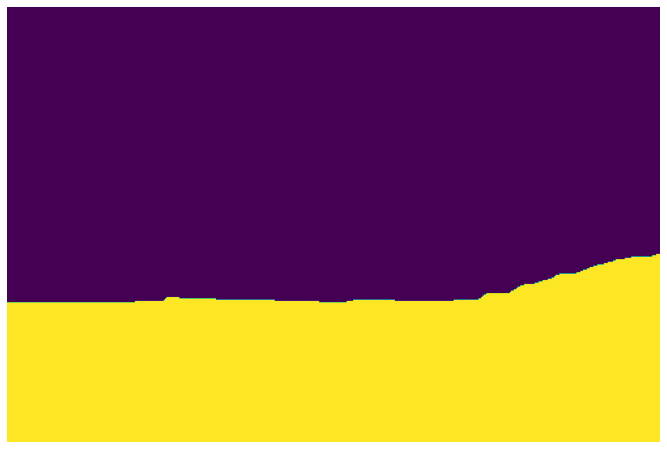

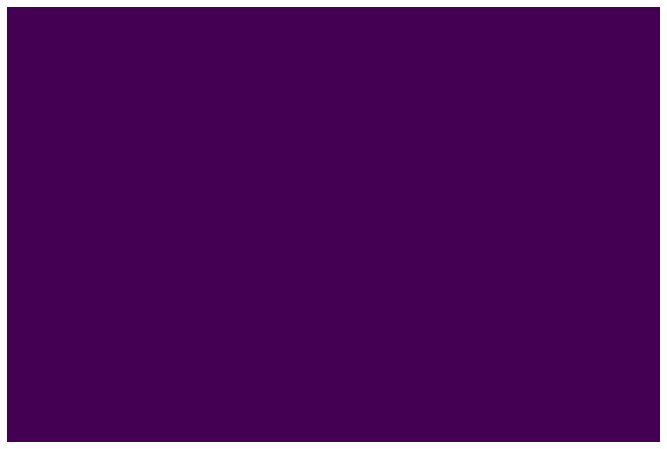

In [131]:
from utils.image_utils import get_neighbour
# prune regions
num_regions, labels, stats, centroids = cv2.connectedComponentsWithStats(labels)

for idx in range(num_regions):
    area_ratio = stats[idx][4] / (mask.shape[0] * mask.shape[1])
    pos = stats[idx][1::-1]  # (col1, col0)
    end = pos + stats[idx][3:1:-1]
    left_side = pos[1]
    right_side = end[1]
    width_ratio = (right_side - left_side) / img.shape[1]
    top_side = pos[0]
    bot_side = end[0]

    # remove small regions ( area < 5%) that are not adjacent to bottom or left or right sides
    if area_ratio < 0.1 and bot_side < img.shape[0] and left_side > 0 and right_side < img.shape[1]:
        neigh_idx = get_neighbour(labels, pos, end)
        # print(idx, neigh_idx)
        labels[labels == idx] = neigh_idx
show_img(labels, figsize=(12,8))
    # # merge in sky_index wide regions ( width > 5%) that are adjacent to top
    # if width_ratio > 0.05 and top_side == 0 :
    #     labels[labels == idx] = sky_idx


# merge in sky_index large regions ( area > 10%) that are adjacent to top
# for seascapes
#
# for idx in range(num_regions):
#     area_ratio = stats[idx][4] / (mask.shape[0] * mask.shape[1])
#     pos = stats[idx][1::-1]  # (col1, col0)
#     end = pos + stats[idx][3:1:-1]
#     left_side = pos[0]
#     right_side = end[0]
#     if area_ratio > 0.1 and (left_side == 0 or right_side == img.shape[1]):
#         labels[labels == idx] = sky_idx


new_mask = np.ones_like(mask)
new_mask[labels == sky_idx] = 0
kernal_size=7
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernal_size*2+1, kernal_size*2+1))   # needs to be odd
new_mask = cv2.morphologyEx(new_mask, cv2.MORPH_CLOSE, kernel, iterations=5)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernal_size//2+1, kernal_size//2+1))
new_mask = cv2.morphologyEx(new_mask, cv2.MORPH_DILATE, kernel, iterations=1)
# new_mask = cv2.morphologyEx(new_mask, cv2.MORPH_DILATE, kernel)
show_img(new_mask, figsize=(12,8))

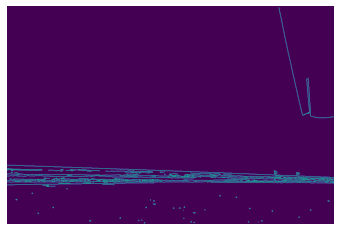

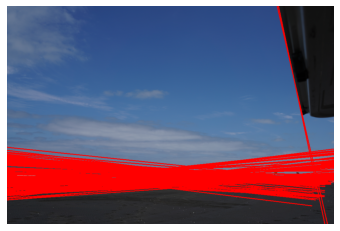

In [ ]:
filename = '/home/jn/data/Tairua/DSC03625.JPG'
filename = '/home/jn/data/Karioitahi_15Jan2022/123MSDCF-35mm/DSC01726.JPG'
# filename = '/home/jn/data/Karioitahi_15Jan2022/117MSDCF-28mm/DSC04377.JPG'
imgrgb = cv2.imread(str(filename))
imgrgb_s = resize(imgrgb, width=6000//6)
gray_img_s = cv2.cvtColor(imgrgb_s, cv2.COLOR_BGR2GRAY)
# gray_img_s = resize(gray_img, width=6000//12)
edges = cv2.Canny(gray_img_s,50,150,apertureSize = 3)
# kernel = np.ones((3,3), np.uint8)
# edges = cv2.dilate(edges, kernel, iterations=1)
show_img(edges)
# edges = cv2.Canny(img_min_pool,50,150,apertureSize = 3)
# show_img(edges)
lines = cv2.HoughLines(edges,1,np.pi/180,100)
for rho,theta in np.squeeze(lines):
    a,b = np.cos(theta), np.sin(theta)
    x0, y0 = a*rho, b*rho
    _len = 1000
    x1, y1 = int(x0 + _len*(-b)), int(y0 + _len*(a))
    x2, y2 = int(x0 - _len*(-b)), int(y0 - _len*(a))
    cv2.line(imgrgb_s,(x1,y1),(x2,y2),(0,0,255),2)
show_img(imgrgb_s, mode='BGR')

len(lines) 5


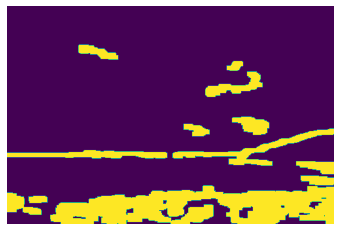

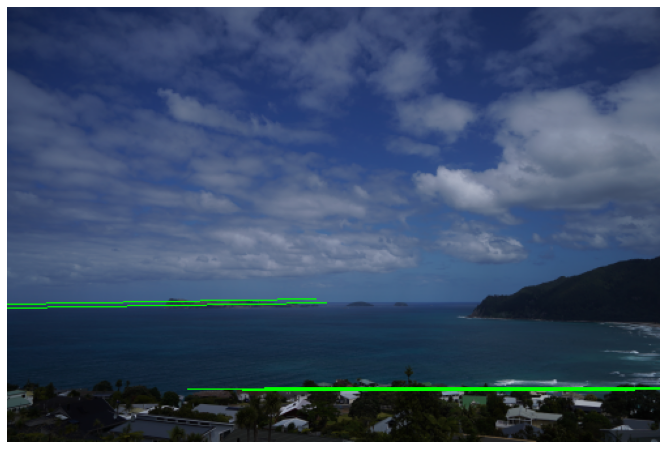

In [65]:
import math
filename = '/home/jn/data/Tairua/DSC03625.JPG'
# filename = '/home/jn/data/Karioitahi_15Jan2022/117MSDCF-28mm/DSC04377.JPG'
# filename = '/home/jn/data/Karioitahi_15Jan2022/123MSDCF-35mm/DSC01726.JPG'

imgrgb = cv2.imread(str(filename))
imgrgb_s = resize(imgrgb, width=6000//12)
gray_img_s = cv2.cvtColor(imgrgb_s, cv2.COLOR_BGR2GRAY)

# edges = cv2.Canny(hsv[:,:,2],50,150,apertureSize = 3)
edges = cv2.Canny(gray_img_s,threshold1=50, threshold2=150,apertureSize = 3)
kernel = np.ones((3,5), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=3) # < --- Added a dilate, check link I provided
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, lines=None, minLineLength=200, maxLineGap=2)
lines = list(np.squeeze(lines))
# lines.sort(key=lambda x: -(x[2]-x[0]))
# lines.sort(key=lambda x: abs(math.degrees(math.atan2(x[3] - x[1], x[2] - x[0]))))

for line in lines:
    [x1,y1,x2,y2]  = line
    angle = abs(math.degrees(math.atan2(y2 - y1, x2 - x1)))
    if angle < 5:
        cv2.line(imgrgb_s,(x1,y1),(x2,y2),(0,255,0),1)
    # print('len', x2-x1)

show_img(edges)
show_img(imgrgb_s, mode='BGR', figsize=(12,8))
print("len(lines)", len(lines))

In [38]:
%timeit -n 3 -r 100 cv2.HoughLinesP(edges,1,np.pi/180,100,lines=None, minLineLength=minLineLength, maxLineGap=maxLineGap)
%timeit -n 3 -r 100 cv2.Canny(gray_img_s,50,150,apertureSize = 3)

1.05 ms ± 94.2 µs per loop (mean ± std. dev. of 100 runs, 3 loops each)
127 µs ± 23.4 µs per loop (mean ± std. dev. of 100 runs, 3 loops each)


In [ ]:
class HoughBundler:
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle

    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])

        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []

        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)

        return np.asarray(merged_lines_all)

# Usage:
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 10)
bundler = HoughBundler(min_distance=10,min_angle=5)
lines = bundler.process_lines(lines)

Felzenszwalb number of segments: 190
SLIC number of segments: 10
Quickshift number of segments: 507


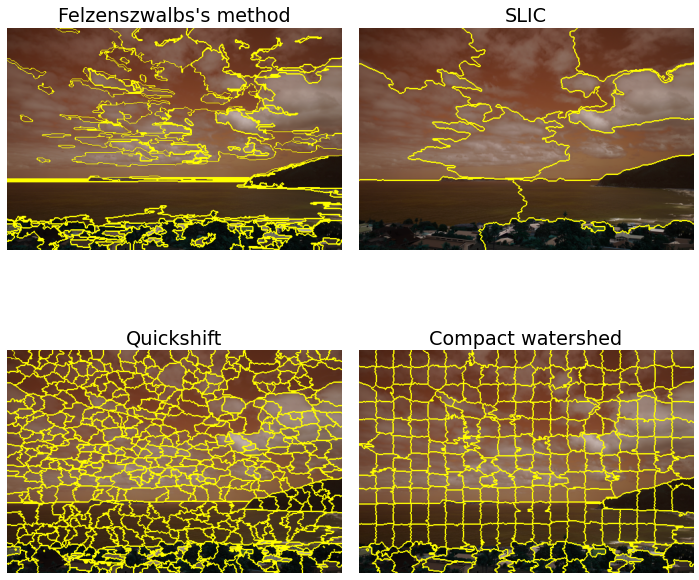

In [27]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = img_as_float(astronaut()[::2, ::2])
filename = '/home/jn/data/Tairua/DSC03625.JPG'
# filename = '/home/jn/data/Karioitahi_15Jan2022/117MSDCF-28mm/DSC04377.JPG'
img = cv2.imread(str(filename))
img = resize(img, width=6000//12)

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=10, compactness=10, sigma=1,
                     start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [29]:
%timeit slic(img, n_segments=10, compactness=10, sigma=1, start_label=1)

81.5 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
val = 127
mask = mask_horizon(img_min_pool, threshold=60)
# mask = 255 - mask
show_img(mask)
num_regions, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
show_img(labels)

<Image layer 'Image' at 0x7f0cc0709a30>

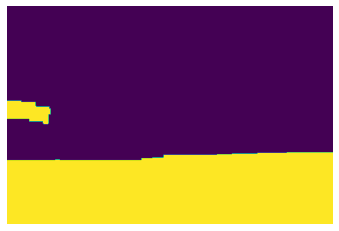

In [18]:
from utils.image_utils import BH_op,find_sky
mask = find_sky(img_min_pool, threshold=60)
show_img(mask)
viewer.add_image(mask*127)

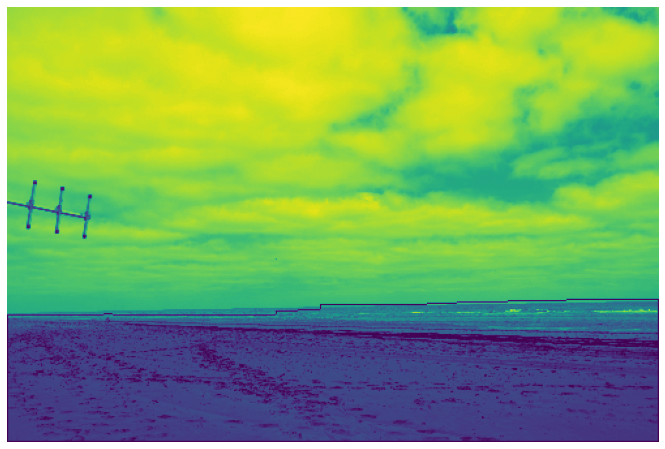

In [17]:
disp_image = img_min_pool.copy()
contours, hierarchy = cv2.findContours(mask * 255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# disp_image = cv2.cvtColor(self.model.image_s, cv2.COLOR_GRAY2BGR)
cv2.drawContours(disp_image, contours, 0, (0), 1)
show_img(disp_image, figsize=(12, 8))
# %timeit find_sky(img_min_pool, threshold=60)

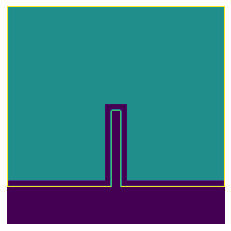

In [204]:
disp_image = np.ones((200,200), 'uint8')*127

disp_image[90:, 90:110] = 0

disp_image[160:, :] = 0

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
mask = cv2.morphologyEx(disp_image, cv2.MORPH_DILATE, kernel, iterations=3)

contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# disp_image = cv2.cvtColor(self.model.image_s, cv2.COLOR_GRAY2BGR)
cv2.drawContours(disp_image, contours, 0, (255), 1)
show_img(disp_image)

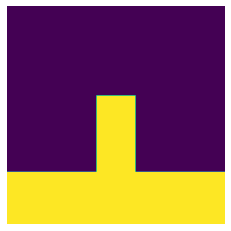

In [208]:
mask = find_sky(disp_image, threshold=60)
# mask = mask_horizon(disp_image, threshold=60)
show_img(mask)
# %timeit cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=10)

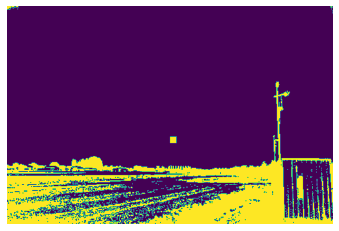

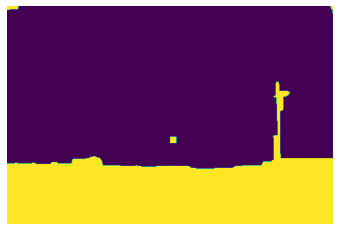

In [128]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
(T, mask) = cv2.threshold(img_min_pool, 60, 255, cv2.THRESH_BINARY_INV)
show_img(mask)
mask2 = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)
show_img(mask2)

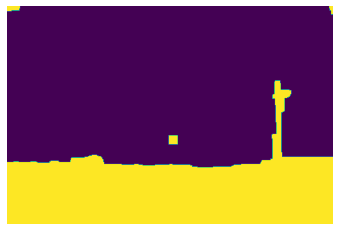

In [129]:
mask3 = cv2.morphologyEx(mask2, cv2.MORPH_DILATE, kernel, iterations=1)
show_img(mask3)

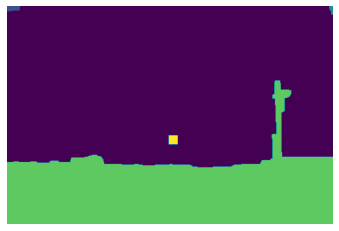

In [130]:
# mask = mask_horizon(img_min_pool, threshold=60)
# mask = mask + 1
num_regions, labels, stats, centroids = cv2.connectedComponentsWithStats(mask3)
show_img(labels)
# viewer.add_image(labels)

In [ ]:
%timeit cv2.connectedComponentsWithStats(mask)

In [ ]:
# if a region's boundaries are not at image boundaries then merge with neighbouring region
for stat in stats:
    pass

In [57]:
stat = stats[4]
area_ratio = stat[4]/(mask.shape[0]*mask.shape[1])
# if diags are not outside mask
idx = 0
pos = stats[idx][1::-1]
end = pos + stats[idx][3:1:-1]

In [58]:
# np.all(mask.shape-end>0)
mask.shape-end

array([86,  0])

In [77]:
for idx in range(5):
    pos = stats[idx][1::-1]  # (col1, col0)
    end = pos + stats[idx][3:1:-1]  # (col3, col2)
    v1 = np.all(pos>0) and np.all(mask.shape-end>0)
    print(v1)

False
False
False
False
True
None
0
0
None
0


1
1
2
3
None


In [113]:
def get_neighbour(labels, pos, end):
    """ get a neighouring region: useful for removing small regions """
    labels_shape = np.array(labels.shape)
    # get  outside points at the diagional points
    pos = np.clip(pos, a_min=0, a_max=labels_shape-1)
    end = np.clip(end, a_min=0, a_max=labels_shape-1)
    pos1 = np.clip(pos-1, a_min=0, a_max=labels_shape-1)
    end1 = np.clip(end+1, a_min=0, a_max=labels_shape-1)
    # if clipped box point is outside ( = a neighbour) then return the neighbour label
    if np.any(pos != pos1):
        return labels[pos1[0],pos1[1]]
    if np.any(end != end1):
        return labels[end1[0],end1[1]]

    return None

In [ ]:
def remove_small_regions(stats):

1 0
2 0
4 0


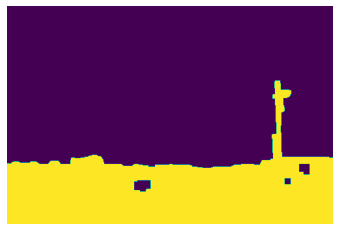

In [122]:
labels_cpy = labels.copy()
for idx in range(5):
    area_ratio = stats[idx,4]/(mask.shape[0]*mask.shape[1])
    if area_ratio < 0.25:
        pos = stats[idx][1::-1]  # (col1, col0)
        end = pos + stats[idx][3:1:-1]
        neigh_idx = get_neighbour(labels_cpy, pos, end)
        print(idx, neigh_idx)
        labels_cpy[labels_cpy==idx] = neigh_idx

show_img(labels_cpy)

array([249, 199,  19,  19, 361], dtype=int32)

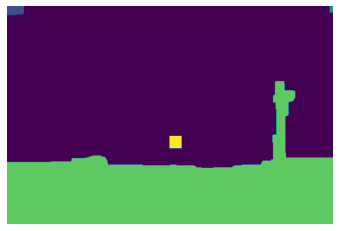

In [108]:
show_img(labels)
for b in stat[:4]:
    if stat[0] > 0:
        reg = labels[stat[0]-1, stat[1]]
stat

In [32]:
print(stats[:10])

[[     0      0    500    248 116611]
 [     0      0     26     14    348]
 [   495      0      5     10     50]
 [     0    115    500    219  49630]
 [   249    199     19     19    361]]


In [ ]:
area_sort = np.argsort(stats[:, -1])
# choose the region that is the largest brightest
brightest = 0
for i in range(min(num_regions, 3)):
    idx = area_sort[-(i+1)]
    b = np.mean(img_min_pool[labels==idx])
    if b > brightest:
        brightest = b
        b_idx = idx
    print(idx, b)
b_idx

In [ ]:
new_mask = np.ones_like(mask)
new_mask[labels==b_idx] = 0
show_img(new_mask)

In [ ]:
labels[]

In [ ]:
(threshold, mask2) = cv2.threshold(img_min_pool, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
viewer.add_image(mask2)

In [ ]:
cmo = BH_op(img_min_pool, (5, 5))
cmo[mask==255] = 0
norm_uint8(cmo)
viewer.add_image(cmo)

In [ ]:
viewer.add_image(scale_image(img, scale=0.125))







In [ ]:
(rows, cols) = (2000, 3000)
center = (2750, 4350)
(_r, _c) = (center[0]-rows//2, center[1]-cols//2)
crop = [_r, _r + rows, _c, _c + cols]
crop = None
images = ImageLoader('Z:/Day2/seq6/images.npy', crop=crop, scale=1, color='Gray')
stack = images._stack

In [ ]:
show_img(images._stack[40], figsize=(12,8), cmap='gray')



In [ ]:
# npstack = np.stack(stack)
# np.save('Z:/Day2/seq6/images.npy', npstack)

# npstack = np.stack(stack)
# np.save('Z:/Day2/seq4/images.npy', npstack)

### Misc ###

In [ ]:
def findpeak(image):
    (r,c) = np.unravel_index(image.argmax(), image.shape)
    # val = image[r,c]
    # putText(image, str(val), fontScale=0.25 )
    # cv2.circle(image, (c,r), 10,(255,255,255))
    return (r,c)

def pyr_down(img):
    return cv2.pyrDown(img, dstsize=(img.shape[1]//2, img.shape[0]//2))

PYRAMID_SCALE=1
tiles = np.load('Z:/Day2/seq6/tiles.npy', allow_pickle=True)
x = np.arange(-10, 10+1, 10)//PYRAMID_SCALE
y = np.arange(-10, 10+1, 10)//PYRAMID_SCALE
xv, yv = np.meshgrid(x, y)

wait_timeout = 500
DISPLAY_SCALE = 2
for i, objlst in enumerate(tiles):
    # tuple(numpy, labelID, pos(r,c), frameID)

    imgs = [obj[0] for obj in objlst]
    # imgs = [pyr_down(obj[0]) for obj in objlst]

    cmos = [BH_op(obj,(5,5)) for obj in imgs]
    cmos = [np.uint8(255*(obj/obj.max())) for obj in cmos]

    if len(cmos) > 0:
        cmo = np.hstack(cmos)
        cmo = scale_image(cv2.applyColorMap(cmo, cv2.COLORMAP_MAGMA),DISPLAY_SCALE)
        cv2.imshow('cmo', cmo)
    else:
        print("No CMOS found")
        continue
    pks = [findpeak(obj) for obj in cmos]

    imgs_disp = []
    magnitudes = []

    for (r,c), img in zip(pks, imgs):
        # assert abs((r-img.shape[0]//2)) < 10, f"pk {(r,c)} is not near center"
        # assert abs((c-img.shape[1]//2)) < 10, f"pk {(r,c)} is not near center"
        if abs((r-img.shape[0]//2)) > 10:
            continue
        if abs((c-img.shape[1]//2)) > 10:
            continue
        disp_img = scale_image(img, DISPLAY_SCALE)
        val = img[r+yv,c+xv].astype(np.int32)
        val = val - val[1,1]

        putText(disp_img, f'{val[0]}' , fontScale=0.5, row=20, color=(0))
        putText(disp_img, f'{val[1]}' , fontScale=0.5, row=35, color=(0))
        putText(disp_img, f'{val[2]}' , fontScale=0.5, row=50, color=(0))
        val[1,1] = val.max()
        if val.min() < 10 and val.min() < val.max()//2:
            putText(disp_img, 'CLOUD' , fontScale=0.5, row=70, color=(0))

        cv2.circle(disp_img, (c*DISPLAY_SCALE,r*DISPLAY_SCALE), 10*DISPLAY_SCALE,(255,255,255))
        gX = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        gY = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        mag = np.sqrt((gX ** 2) + (gY ** 2))
        magnitudes.append(cv2.convertScaleAbs(mag))

        imgs_disp.append(disp_img)

    if len(imgs_disp) > 0:
        img_disp = np.hstack(imgs_disp)
        cv2.imshow('Tiles', img_disp)
        magnitude = np.hstack(magnitudes)
        # cv2.imshow('magnitude', magnitude/magnitude.max())
        cv2.imshow('magnitude', scale_image(cv2.applyColorMap(magnitude, cv2.COLORMAP_MAGMA),DISPLAY_SCALE))

    k = cv2.waitKey(wait_timeout)
    if k == ord('q') or k == 27:
        break
    if k == ord(' '):
        wait_timeout = 0
    if k == ord('g'):
        wait_timeout = 600

cv2.destroyAllWindows()

In [ ]:
show_img(img_disp, figsize=(12,8), title='Src Image', cmap='gray')
show_img(cmo, figsize=(12,8), title='CMO')

### run in opencv

In [ ]:
def mask_horizon(image, shrink=None):
    if shrink is not None:
        image = resize(image, width=image.shape[1]//shrink)
    blur = cv2.GaussianBlur(image,(3,3),0)
    (T, threshInv) = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    mask = cv2.morphologyEx(threshInv, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    return mask



In [ ]:
def findpeak(image):
    (r,c) = np.unravel_index(image.argmax(), image.shape)
    # val = image[r,c]
    # putText(image, str(val), fontScale=0.25 )
    # cv2.circle(image, (c,r), 10,(255,255,255))
    return (r,c)
PYRAMID_SCALE=1
tiles = np.load('Z:/Day2/seq6/tiles.npy', allow_pickle=True)
x = np.arange(-10, 10+1, 10)//PYRAMID_SCALE
y = np.arange(-10, 10+1, 10)//PYRAMID_SCALE
xv, yv = np.meshgrid(x, y)

wait_timeout = 500
DISPLAY_SCALE = 2
for i, objlst in enumerate(tiles):
    # tuple(numpy, labelID, pos(r,c), frameID)
    imgs = [scale_image(obj[0], 1/PYRAMID_SCALE) for obj in objlst]

    cmos = [BH_op(obj,(5,5)) for obj in imgs]
    cmos = [(obj/obj.max()*255).astype(np.uint8) for obj in cmos]
    if len(cmos) > 0:
        cmo = np.hstack(cmos)
        cmo = scale_image(cv2.applyColorMap(cmo, cv2.COLORMAP_MAGMA),DISPLAY_SCALE)
        cv2.imshow('cmo', cmo)
    else:
        print("No CMOS found")
        continue
    pks = [findpeak(obj) for obj in cmos]

    imgs_disp = []
    magnitudes = []

    for (r,c), img in zip(pks, imgs):
        # assert abs((r-img.shape[0]//2)) < 10, f"pk {(r,c)} is not near center"
        # assert abs((c-img.shape[1]//2)) < 10, f"pk {(r,c)} is not near center"
        if abs((r-img.shape[0]//2)) > 10:
            continue
        if abs((c-img.shape[1]//2)) > 10:
            continue
        disp_img = scale_image(img, DISPLAY_SCALE)
        val = img[r+yv,c+xv].astype(np.int32)
        val = val - val[1,1]

        putText(disp_img, f'{val[0]}' , fontScale=0.5, row=20)
        putText(disp_img, f'{val[1]}' , fontScale=0.5, row=35)
        putText(disp_img, f'{val[2]}' , fontScale=0.5, row=50)
        val[1,1] = val.max()
        if val.min() < 10 and val.min() < val.max()//2:
            putText(disp_img, 'CLOUD' , fontScale=0.5, row=70)

        cv2.circle(disp_img, (c*DISPLAY_SCALE,r*DISPLAY_SCALE), 10*DISPLAY_SCALE,(255,255,255))
        gX = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        gY = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        mag = np.sqrt((gX ** 2) + (gY ** 2))
        magnitudes.append(cv2.convertScaleAbs(mag))

        imgs_disp.append(disp_img)

    if len(imgs_disp) > 0:
        img_disp = np.hstack(imgs_disp)
        cv2.imshow('Tiles', img_disp)
        magnitude = np.hstack(magnitudes)
        # cv2.imshow('magnitude', magnitude/magnitude.max())
        cv2.imshow('magnitude', scale_image(cv2.applyColorMap(magnitude, cv2.COLORMAP_MAGMA),DISPLAY_SCALE))

    k = cv2.waitKey(wait_timeout)
    if k == ord('q') or k == 27:
        break
    if k == ord(' '):
        wait_timeout = 0
    if k == ord('g'):
        wait_timeout = 600

cv2.destroyAllWindows()